In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from jax import jit, random
import optax as ox
import numpy as np
import gpjax as gpx
import tensorflow as tf
import jax
import logger as logging
logger = logging.init_logger(log_level=logging.INFO)
from jax import config
config.update("jax_enable_x64", True)
%matplotlib inline

/vol/bitbucket/yn621/envs/individual-project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-08-19 15:45:26.325604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vol/lab/mac/cadence/smv/lib


# Model

In [2]:
from models import FCN
from neural_tangents import stax
from snngp import SNNGP
from snngp_inference import select_inducing_points
from metrics import RMSE

model = FCN
model_params = dict(
            kernel_batch_size=0, 
            device_count=-1, 
            num_layers=10,
            hid_dim=1, 
            out_dim=1,
            nonlinearity=stax.Relu
            )

# Dataset

In [15]:
n = 5000
noise = 0.2
key = jr.PRNGKey(123)
X = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(X)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = gpx.Dataset(X=X, y=y)

X_test = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)
f_true = f(X_test)

100%|██████████| 49/49 [00:06<00:00,  7.61it/s]
[2022-08-19 15:53:33,656 INFO] (snngp_inference:59) inducing_points shape: (50, 1)


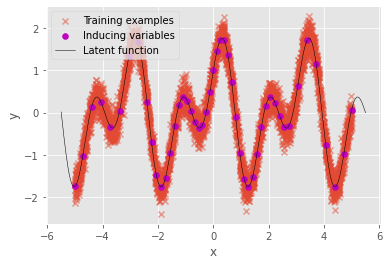

In [17]:
X_m, indices = select_inducing_points("greedy", X, m, model, jnp.array([1, 1]), model_params)
# X_m = X
plt.scatter(X, y, label='Training examples', marker='x', alpha=0.5)
plt.scatter(X_m, f(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig("figures/1d_data.pdf", bbox_inches='tight')

In [3]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 50

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

D = gpx.Dataset(X=X, y=y)

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

X.shape, y.shape, X_test.shape, f_true.shape

((1000, 1), (1000, 1), (1000, 1), (1000, 1))

100%|██████████| 49/49 [00:03<00:00, 13.19it/s]
[2022-08-19 15:52:11,853 INFO] (snngp_inference:59) inducing_points shape: (50, 1)


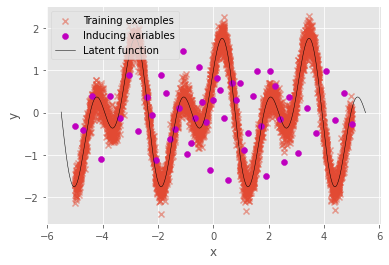

In [16]:
X_m, indices = select_inducing_points("greedy", X, m, model, jnp.array([1, 1]), model_params)
# X_m = X
plt.scatter(X, y, label='Training examples', marker='x', alpha=0.5)
plt.scatter(X_m, func(X_m), label='Inducing variables', c='m')
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig("figures/1d_data.pdf", bbox_inches='tight')

In [26]:
from gpjax.config import add_parameter
import distrax as dx

bij_fn = lambda x: jnp.logaddexp(x, 0.)
bij = dx.Lambda(bij_fn)

add_parameter("sigmas", bij)

In [32]:
from chex import dataclass
from jaxtyping import f64
from snngp import init_kernel_fn

@dataclass
class NNGPKernel(gpx.kernels.Kernel):
    def __post_init__(self):
        self._params = {"sigmas": jnp.array([4.33574371, 6.78895193])}

    def __call__(self, x: f64["1 D"], y: f64["1 D"], params: dict) -> f64["1"]:
        kernel_fn = init_kernel_fn(model, params["sigmas"], model_params)
        K = kernel_fn(x, y, "nngp")
        print(x.shape, y.shape, K.shape)
        return K

# SNNGP Demo

In [33]:
likelihood = gpx.Gaussian(num_datapoints=n)
# prior = gpx.Prior(kernel=gpx.RBF())
prior = gpx.Prior(kernel=NNGPKernel())
p =  prior * likelihood
q = gpx.VariationalGaussian(prior=prior, inducing_inputs=X_m)

svgp = gpx.StochasticVI(posterior=p, variational_family=q)
params, trainables, constrainers, unconstrainers = gpx.initialise(svgp)
# params = gpx.transform(params, unconstrainers)

loss_fn = jit(svgp.elbo(D, constrainers, negative=True))

Dbatched = D.cache().repeat().shuffle(D.n).batch(batch_size=128).prefetch(buffer_size=1)

optimiser = ox.adam(learning_rate=0.01)

learned_params = gpx.fit_batches(
    objective = loss_fn,
    params = params,
    trainables = trainables,
    train_data = Dbatched,
    optax_optim = optimiser,
    n_iters=4000,
)
learned_params = gpx.transform(learned_params, constrainers)

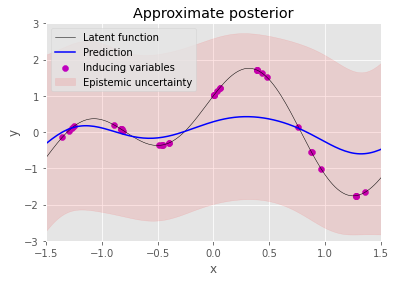

In [24]:
latent_dist = q(learned_params)(X_test)
predictive_dist = likelihood(latent_dist, learned_params)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

X_m = learned_params["variational_family"]["inducing_inputs"]
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, meanf, label='Prediction', c='b')
plt.scatter(X_m, f(X_m), label='Inducing variables', c='m')
plt.fill_between(X_test.ravel(), 
                 meanf.ravel() + 2 * sigma.ravel(), 
                 meanf.ravel() - 2 * sigma.ravel(),
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-3.0, 3.0)
plt.xlim(-1.5, 1.5)
plt.legend()